In [132]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from tqdm import tqdm

import tensorflow as tf

In [2]:
def read_image(path, color_format='rgb'):
    image = cv2.imread(path)
    if color_format.lower() == 'rgb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    image = image.astype(np.float32)/255.
    
    return image

In [135]:
class DataLoader:
    def __init__(self, dir_path='dataset/Market-1501-v15.09.15/gt_bbox',
                 image_reader=None, batch_size=16):
        self.dir_path = dir_path
        self.image_reader = image_reader
        self.batch_size = batch_size
        
        self._load()
        
    def _get_image(self, path):
        return self.image_reader(path)
    
    def _load(self):
        paths = os.listdir(self.dir_path)
        self.path_ids = {}
        for path in paths:
            if path != 'Thumbs.db':
                id_ = int(path.split('_')[0])
                if id_ in self.path_ids.keys():
                    self.path_ids[id_].append(os.path.join(self.dir_path, path))
                else:
                    self.path_ids[id_] = [os.path.join(self.dir_path, path)]
                
    def generator(self):
        while True:
            top_x1 = []
            middle_x1 = []
            bottom_x1 = []
            
            top_x2 = []
            middle_x2 = []
            bottom_x2 = []
            
            batch_x1 = []
            batch_x2 = []
            batch_y = []
            
            for _ in range(self.batch_size):
                if np.random.choice([0, 1]):
                    id_ = np.random.choice(np.arange(1, 1501+1))
                    image = self._get_image(np.random.choice(self.path_ids[id_]))
                    h = int(image.shape[0]/3)
                    top_x1.append(image[0:h,])
                    middle_x1.append(image[h:h*2,])
                    bottom_x1.append(image[h*2:,])
                    
                    image = self._get_image(np.random.choice(self.path_ids[id_]))
                    h = int(image.shape[0]/3)
                    top_x2.append(image[0:h,])
                    middle_x2.append(image[h:h*2,])
                    bottom_x2.append(image[h*2:,])
                    
                    batch_y.append([1])
                else:
                    id_ = np.random.choice(np.arange(1, 1501+1))
                    image = self._get_image(np.random.choice(self.path_ids[id_]))
                    h = int(image.shape[0]/3)
                    top_x1.append(image[0:h,])
                    middle_x1.append(image[h:h*2,])
                    bottom_x1.append(image[h*2:,])
                    
                    id_ = np.random.choice(np.arange(1, 1501+1))
                    image = self._get_image(np.random.choice(self.path_ids[id_]))
                    h = int(image.shape[0]/3)
                    top_x2.append(image[0:h,])
                    middle_x2.append(image[h:h*2,])
                    bottom_x2.append(image[h*2:,])
                    
                    batch_y.append([0])
                   
            top_x1 = np.array(top_x1)
            middle_x1 = np.array(middle_x1)
            bottom_x1 = np.array(bottom_x1)
            
            top_x2 = np.array(top_x2)
            middle_x2 = np.array(middle_x2)
            bottom_x2 = np.array(bottom_x2)
            
            yield [top_x1, middle_x1, bottom_x1], [top_x2, middle_x2, bottom_x2], np.array(batch_y)

In [136]:
def visualize(x1, x2, y, index=0):
    fig, ax = plt.subplots(3, 2)
    ax[0, 0].imshow(x1[0][index])
    ax[1, 0].imshow(x1[1][index])
    ax[2, 0].imshow(x1[2][index])
    
    ax[0, 1].imshow(x2[0][index])
    ax[1, 1].imshow(x2[1][index])
    ax[2, 1].imshow(x2[2][index])
    
    if int(y[index]) == 0:
        ax[0, 1].set_title('Different')
    else:
        ax[0, 1].set_title('Same')
        
    plt.show()

In [150]:
data_loader = DataLoader(dir_path='dataset/Market-1501-v15.09.15/gt_bbox',
                         image_reader=read_image,
                         batch_size=5)
gen = data_loader.generator()

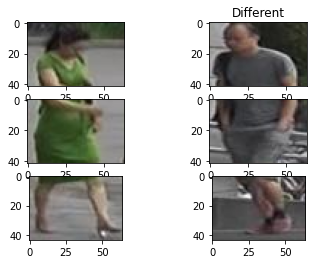

In [151]:
x1, x2, y = next(gen)
visualize(x1, x2, y, index=0)

In [142]:
def conv_block(input_tensor, filters, max_pool=True, name='ConvBlock'):
    with tf.variable_scope(name):
        net = tf.keras.layers.Conv2D(filters, (3, 3), 
                                     kernel_initializer='glorot_uniform', 
                                     padding='same')(input_tensor)
        net = tf.keras.layers.LeakyReLU()(net)
        
        if max_pool:
            net = tf.keras.layers.MaxPooling2D((2, 2))(net)
        
    return net

In [143]:
def feature_extractor(input_tensor1, input_tensor2, name='Feature_Extractor'):
    with tf.variable_scope(name):
        with tf.variable_scope('Branch-1'):
            net1 = conv_block(input_tensor1, filters=16, name='ConvBlock_1')
            net1 = conv_block(net1, filters=16, name='ConvBlock_2')

        with tf.variable_scope('Branch-2'):
            net2 = conv_block(input_tensor2, filters=16, name='ConvBlock_1')
            net2 = conv_block(net2, filters=16, name='ConvBlock_2')

        diff = net1 - net2

        net = conv_block(diff, filters=8, max_pool=False)
        net = conv_block(net, filters=1, max_pool=False)

        net = tf.keras.layers.Flatten()(net)
        net = tf.keras.layers.Dense(128)(net)
        net = tf.keras.layers.LeakyReLU()(net)
        
    return net

In [144]:
def network(image1, image2):
    top_features = feature_extractor(image1[0], image2[0], name='Top_Feature_Extractor')
    middle_features = feature_extractor(image1[1], image2[1], name='Middle_Feature_Extractor')
    bottom_features = feature_extractor(image1[2], image2[2], name='Bottom_Feature_Extractor')
    
    fused = tf.add(tf.add(top_features, middle_features), bottom_features)
    net = tf.keras.layers.Dense(128)(fused)
    net = tf.keras.layers.LeakyReLU()(net)
    net = tf.keras.layers.Dense(1)(net)
    net = tf.math.sigmoid(net)
    
    return net

In [145]:
def binary_accuracy(y_true, y_pred):
    with tf.variable_scope('Accuracy'):
        return tf.keras.backend.mean(tf.keras.backend.equal(y_true, 
                                                            tf.keras.backend.round(y_pred)))

In [153]:
epochs = 40
steps = 5
batch_size = 5

In [154]:
data_loader = DataLoader(dir_path='dataset/Market-1501-v15.09.15/gt_bbox',
                         image_reader=read_image,
                         batch_size=batch_size)
gen = data_loader.generator()

In [157]:
graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    h = int(128/3)
    top1 = tf.placeholder(tf.float32, [None, h, 64, 3])
    middle1 = tf.placeholder(tf.float32, [None, h, 64, 3])
    bottom1 = tf.placeholder(tf.float32, [None, 128-2*h, 64, 3])
    
    top2 = tf.placeholder(tf.float32, [None, h, 64, 3])
    middle2 = tf.placeholder(tf.float32, [None, h, 64, 3])
    bottom2 = tf.placeholder(tf.float32, [None, 128-2*h, 64, 3])
    
    y_tensor = tf.placeholder(tf.float32, [None, 1])
    
    output = network([top1, middle1, bottom1], [top2, middle2, bottom2])
    
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true=y_tensor, y_pred=output))
        loss_summary = tf.summary.scalar('Loss', loss)
        
    accuracy = binary_accuracy(y_true=y_tensor, y_pred=output)
    acc_summary = tf.summary.scalar('Accuracy', accuracy)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    grads = optimizer.compute_gradients(loss=loss)
    grad_summary = []
    for grad_var_pair in grads:
        curr_grad = grad_var_pair[0]
        curr_var = grad_var_pair[1]
        if curr_grad is not None:
            name = curr_var.name.replace(':', "_")
            grad_summary.append(tf.summary.histogram(name, curr_grad))
    grad_summary_op = tf.summary.merge(grad_summary)
    train_op = optimizer.apply_gradients(grads_and_vars=grads)
    
    sess.run(tf.global_variables_initializer())
    
    summary_writer = tf.summary.FileWriter('logs', graph)
    
    counter = 0
    
    for epoch in range(epochs):
        batch_loss = []
        batch_acc = []
        print("Epoch {} of {}".format(epoch+1, epochs))
        for _ in tqdm(range(steps)):
            image1, image2, y = next(gen)
            loss_val, acc_val, _ = sess.run([loss, accuracy, train_op], 
                                             feed_dict={top1: image1[0], middle1: image1[1], bottom1: image1[2],
                                                        top2: image2[0], middle2: image2[1], bottom2: image2[2],
                                                        y_tensor: y})
            batch_loss.append(loss_val)
            batch_acc.append(acc_val)
            counter += 1
            if counter%50:
                l_summ, a_summ, grads = sess.run([loss_summary, acc_summary, grad_summary_op], 
                                                 feed_dict={top1: image1[0], middle1: image1[1], bottom1: image1[2],
                                                            top2: image2[0], middle2: image2[1], bottom2: image2[2],
                                                            y_tensor: y})
                summary_writer.add_summary(l_summ, counter)
                summary_writer.add_summary(a_summ, counter)
                summary_writer.add_summary(grads, counter)
            
        print('Loss: {:.05f}, Accuracy: {:.05f}'.format(np.mean(batch_loss), np.mean(batch_acc)))
    
    
summary_writer.close()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 of 40


 40%|████      | 2/5 [00:00<00:00, 15.76it/s]

Loss: 0.70666, Accuracy: 0.48000
Epoch 2 of 40


 40%|████      | 2/5 [00:00<00:00, 16.95it/s]

Loss: 0.69228, Accuracy: 0.52000
Epoch 3 of 40


 40%|████      | 2/5 [00:00<00:00, 15.44it/s]

Loss: 0.71186, Accuracy: 0.44000
Epoch 4 of 40


 40%|████      | 2/5 [00:00<00:00, 15.52it/s]

Loss: 0.69627, Accuracy: 0.52000
Epoch 5 of 40


 40%|████      | 2/5 [00:00<00:00, 17.56it/s]

Loss: 0.71504, Accuracy: 0.56000
Epoch 6 of 40


 40%|████      | 2/5 [00:00<00:00, 16.05it/s]

Loss: 0.69256, Accuracy: 0.56000
Epoch 7 of 40


 40%|████      | 2/5 [00:00<00:00, 16.02it/s]

Loss: 0.70096, Accuracy: 0.48000
Epoch 8 of 40


 40%|████      | 2/5 [00:00<00:00, 16.41it/s]

Loss: 0.67212, Accuracy: 0.64000
Epoch 9 of 40


 40%|████      | 2/5 [00:00<00:00, 15.42it/s]

Loss: 0.73911, Accuracy: 0.32000
Epoch 10 of 40


 40%|████      | 2/5 [00:00<00:00, 13.26it/s]

Loss: 0.73137, Accuracy: 0.32000
Epoch 11 of 40


 40%|████      | 2/5 [00:00<00:00, 15.35it/s]

Loss: 0.69431, Accuracy: 0.64000
Epoch 12 of 40


 40%|████      | 2/5 [00:00<00:00, 15.55it/s]

Loss: 0.68534, Accuracy: 0.60000
Epoch 13 of 40


 40%|████      | 2/5 [00:00<00:00, 15.60it/s]

Loss: 0.70201, Accuracy: 0.48000
Epoch 14 of 40


 40%|████      | 2/5 [00:00<00:00, 13.87it/s]

Loss: 0.67946, Accuracy: 0.56000
Epoch 15 of 40


 40%|████      | 2/5 [00:00<00:00, 16.37it/s]

Loss: 0.71229, Accuracy: 0.36000
Epoch 16 of 40


 40%|████      | 2/5 [00:00<00:00, 16.10it/s]

Loss: 0.70728, Accuracy: 0.32000
Epoch 17 of 40


 40%|████      | 2/5 [00:00<00:00, 16.49it/s]

Loss: 0.68532, Accuracy: 0.60000
Epoch 18 of 40


 40%|████      | 2/5 [00:00<00:00, 16.18it/s]

Loss: 0.69328, Accuracy: 0.56000
Epoch 19 of 40


 40%|████      | 2/5 [00:00<00:00, 15.79it/s]

Loss: 0.69493, Accuracy: 0.56000
Epoch 20 of 40


 40%|████      | 2/5 [00:00<00:00, 15.76it/s]

Loss: 0.69450, Accuracy: 0.52000
Epoch 21 of 40


 40%|████      | 2/5 [00:00<00:00, 15.84it/s]

Loss: 0.70165, Accuracy: 0.48000
Epoch 22 of 40


 40%|████      | 2/5 [00:00<00:00, 15.00it/s]

Loss: 0.70004, Accuracy: 0.52000
Epoch 23 of 40


 40%|████      | 2/5 [00:00<00:00, 15.53it/s]

Loss: 0.67874, Accuracy: 0.60000
Epoch 24 of 40


 40%|████      | 2/5 [00:00<00:00, 15.67it/s]

Loss: 0.69472, Accuracy: 0.44000
Epoch 25 of 40


 40%|████      | 2/5 [00:00<00:00, 16.32it/s]

Loss: 0.70820, Accuracy: 0.40000
Epoch 26 of 40


 40%|████      | 2/5 [00:00<00:00, 15.41it/s]

Loss: 0.68424, Accuracy: 0.72000
Epoch 27 of 40


 40%|████      | 2/5 [00:00<00:00, 15.73it/s]

Loss: 0.72501, Accuracy: 0.60000
Epoch 28 of 40


 40%|████      | 2/5 [00:00<00:00, 14.93it/s]

Loss: 0.68016, Accuracy: 0.60000
Epoch 29 of 40


 40%|████      | 2/5 [00:00<00:00, 15.51it/s]

Loss: 0.70563, Accuracy: 0.52000
Epoch 30 of 40


 40%|████      | 2/5 [00:00<00:00, 16.06it/s]

Loss: 0.70612, Accuracy: 0.48000
Epoch 31 of 40


 40%|████      | 2/5 [00:00<00:00, 16.34it/s]

Loss: 0.69550, Accuracy: 0.44000
Epoch 32 of 40


 40%|████      | 2/5 [00:00<00:00, 14.70it/s]

Loss: 0.66302, Accuracy: 0.60000
Epoch 33 of 40


 40%|████      | 2/5 [00:00<00:00, 15.08it/s]

Loss: 0.74449, Accuracy: 0.48000
Epoch 34 of 40


 40%|████      | 2/5 [00:00<00:00, 15.01it/s]

Loss: 0.69605, Accuracy: 0.52000
Epoch 35 of 40


 40%|████      | 2/5 [00:00<00:00, 17.02it/s]

Loss: 0.68644, Accuracy: 0.56000
Epoch 36 of 40


 40%|████      | 2/5 [00:00<00:00, 16.54it/s]

Loss: 0.72847, Accuracy: 0.36000
Epoch 37 of 40


 40%|████      | 2/5 [00:00<00:00, 16.37it/s]

Loss: 0.70326, Accuracy: 0.48000
Epoch 38 of 40


 40%|████      | 2/5 [00:00<00:00, 15.56it/s]

Loss: 0.69718, Accuracy: 0.40000
Epoch 39 of 40


 40%|████      | 2/5 [00:00<00:00, 14.94it/s]

Loss: 0.69783, Accuracy: 0.44000
Epoch 40 of 40


100%|██████████| 5/5 [00:00<00:00, 16.35it/s]

Loss: 0.67262, Accuracy: 0.68000
